In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [66]:
holidays = pd.read_csv('/content/drive/MyDrive/holidays_events.csv',parse_dates=['date'])
oil = pd.read_csv('/content/drive/MyDrive/oil.csv',parse_dates=['date'])
stores = pd.read_csv('/content/drive/MyDrive/stores.csv')
transactions = pd.read_csv('/content/drive/MyDrive/transactions.csv',parse_dates=['date'])

In [67]:
train = pd.read_csv('/content/drive/MyDrive/train.csv',parse_dates=['date'])
test = pd.read_csv('/content/drive/MyDrive/test.csv',parse_dates=['date'])

In [68]:
df=train.copy()
df_test=test.copy()


In [69]:
print(f'The range of date:{str(df.date.iloc[0]).split()[0]} to {str(df.date.iloc[-1]).split()[0]}')
print(f'The range of test set:{str(df_test.date.iloc[0]).split()[0]} to {str(df_test.date.iloc[-1]).split()[0]}')

The range of date:2013-01-01 to 2017-08-15
The range of test set:2017-08-16 to 2017-08-31


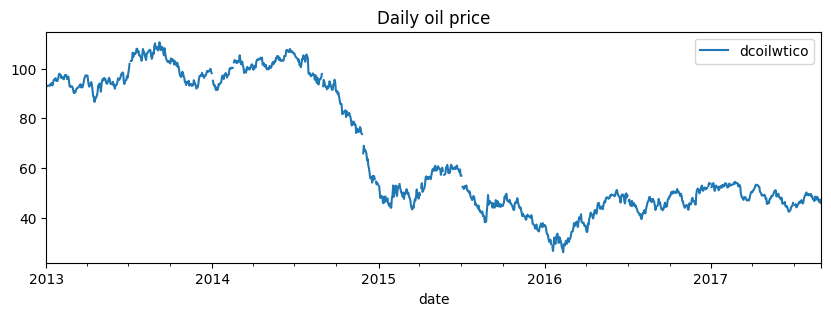

In [70]:
oil.plot(x='date',y='dcoilwtico', figsize=(10,3), title= 'Daily oil price' )
plt.xlable="Date"
plt.ylable="Oil price"
plt.show()


In [71]:
oil.dcoilwtico=oil.dcoilwtico.bfill()
oil=oil.set_index('date').resample(rule= "D").ffill().reset_index()

In [72]:
holidays.locale.unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [73]:
holidays.locale=holidays.locale.map({'Regional':1, 'Local':2, 'National':3})
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,2,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,1,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,2,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,2,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,2,Riobamba,Cantonizacion de Riobamba,False


In [74]:
holidays[holidays.date.duplicated(keep=False)]

,date,type,locale,locale_name,description,transferred
7,2012-06-25,Holiday,1,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,2,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,2,Machala,Fundacion de Machala,False
10,2012-07-03,Holiday,2,Santo Domingo,Fundacion de Santo Domingo,False
11,2012-07-03,Holiday,2,El Carmen,Cantonizacion de El Carmen,False
...,...,...,...,...,...,...
319,2017-07-03,Holiday,2,Santo Domingo,Fundacion de Santo Domingo,False
341,2017-12-08,Holiday,2,Loja,Fundacion de Loja,False
342,2017-12-08,Transfer,2,Quito,Traslado Fundacion de Quito,False
344,2017-12-22,Holiday,2,Salinas,Cantonizacion de Salinas,False


In [75]:
# Use groupby and max to get the max locale value on a holiday
holidays = holidays.groupby('date').max(numeric_only=True)
holidays.reset_index(inplace=True)

# Dropping transferred column
holidays.drop('transferred',axis=1,inplace=True)
holidays.head()

,date,locale
0,2012-03-02,2
1,2012-04-01,1
2,2012-04-12,2
3,2012-04-14,2
4,2012-04-21,2


In [76]:
df=pd.merge(df,oil,on='date', how= 'left')
df=pd.merge(df,stores,on='store_nbr', how="left")
df=pd.merge(df,holidays, on='date', how='left')

In [77]:
df.locale.fillna(0,inplace= True)
df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
city           0
state          0
type           0
cluster        0
locale         0
dtype: int64

In [78]:
df_test=pd.merge(df_test,oil,on='date',how='left')
df_test=pd.merge(df_test,stores,on='store_nbr',how='left')
df_test=pd.merge(df_test,holidays,on='date',how='left')
df_test.locale.fillna(0,inplace=True)
df_test.isnull().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dcoilwtico     0
city           0
state          0
type           0
cluster        0
locale         0
dtype: int64

In [79]:
df.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [80]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster,locale
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Quito,Pichincha,D,13,3.0
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Quito,Pichincha,D,13,3.0
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Quito,Pichincha,D,13,3.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Quito,Pichincha,D,13,3.0
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Quito,Pichincha,D,13,3.0


In [81]:
df.family=df.family.map({'AUTOMOTIVE':1, 'BABY CARE':2, 'BEAUTY':3, 'BEVERAGES':4, 'BOOKS':5,
       'BREAD/BAKERY':6, 'CELEBRATION':7, 'CLEANING':8, 'DAIRY':9, 'DELI':10, 'EGGS':11,
       'FROZEN FOODS':12, 'GROCERY I':13, 'GROCERY II':14, 'HARDWARE':15,
       'HOME AND KITCHEN I':16, 'HOME AND KITCHEN II':17, 'HOME APPLIANCES':18,
       'HOME CARE':19, 'LADIESWEAR':20, 'LAWN AND GARDEN':21, 'LINGERIE':22,
       'LIQUOR,WINE,BEER':23, 'MAGAZINES':24, 'MEATS':25, 'PERSONAL CARE':26,
       'PET SUPPLIES':27, 'PLAYERS AND ELECTRONICS':28, 'POULTRY':29,
       'PREPARED FOODS':30, 'PRODUCE':31, 'SCHOOL AND OFFICE SUPPLIES':32,
       'SEAFOOD':33})

In [82]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster,locale
0,0,2013-01-01,1,1,0.0,0,93.14,Quito,Pichincha,D,13,3.0
1,1,2013-01-01,1,2,0.0,0,93.14,Quito,Pichincha,D,13,3.0
2,2,2013-01-01,1,3,0.0,0,93.14,Quito,Pichincha,D,13,3.0
3,3,2013-01-01,1,4,0.0,0,93.14,Quito,Pichincha,D,13,3.0
4,4,2013-01-01,1,5,0.0,0,93.14,Quito,Pichincha,D,13,3.0


In [83]:
df.type=df.type.map({'D':4, 'C':3, 'B':2, 'E':5, 'A':1})

In [84]:
train_ds = df.iloc[:,[0,2,3,5,6,9,10,11]]
test_ds = df_test.iloc[:,[0,2,3,4,5,8,9,10]]
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Applying level encoding on each column with categorical data
train_ds = train_ds.apply(lambda col: label_encoder.fit_transform(col) if col.dtype == 'object' else col)
test_ds = test_ds.apply(lambda col: label_encoder.fit_transform(col) if col.dtype == 'object' else col)

In [85]:
train_ds.dcoilwtico=train_ds.dcoilwtico.astype(int)
test_ds.dcoilwtico=test_ds.dcoilwtico.astype(int)

In [86]:
target = df['sales']
X = train_ds.drop('id',axis=1)
y = target.values


In [87]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_trn= scaler.fit_transform(X)
test_trn=scaler.fit_transform(test_ds)

In [88]:
# Assuming X contains the features and y contains the labels
X_train, X_test, y_train, y_test = train_test_split(X_trn, y, test_size=0.2, random_state=42)

In [89]:
# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 993816.4674888673
R-squared Score: 0.200348410721508


In [90]:
y_pred_flattened = y_pred.flatten()
submission = {
    "id": df_test['id'].values,
    "sales": y_pred_flattened
}
submission

{'id': array([3000888, 3000889, 3000890, ..., 3029397, 3029398, 3029399]),
 'sales': array([2853.79748931,  524.75884494,  225.76456183, ...,  287.64800923,
         353.2676828 ,  414.88080968])}

In [92]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model's performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error: {mse_rf}")
print(f"Random Forest R-squared Score: {r2_rf}")


Random Forest Mean Squared Error: 212699.81802874606
Random Forest R-squared Score: 0.8288559778490106
